## Ebola infected Macaque Sample Composition Trajectory Identification

```
Indices:

- c cell type
- g genes
- m samples
- k deformation polynomial degree
```

In [ ]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
from time_deconv.time_deconv import *

## Parameter Configuration

In [3]:
device = torch.device("cuda:0")
dtype = torch.float32
dtype_np = np.float32

## Train Model

In [4]:
bulk_anndata_path = "/home/nbarkas/disk2/deconvolution_method/datasets/ebov/load_data_python/ebov_bulk.h5ad"
sc_anndata_path = "/home/nbarkas/disk2/deconvolution_method/datasets/ebov/load_data_python/ebov_sc.h5ad"

In [5]:
with open(bulk_anndata_path, 'rb') as fh:
    bulk_anndata  = anndata.read_h5ad(fh)
with open(sc_anndata_path, 'rb') as fh:
    sc_anndata = anndata.read_h5ad(fh)

In [6]:
# select samples only after or on tp 0
bulk_anndata = bulk_anndata[bulk_anndata.obs['dpi_time'] >= 0,]

In [7]:
bulk_anndata.shape

(52, 12180)

In [8]:
ebov_dataset = DeconvolutionDataset(
    sc_anndata = sc_anndata,
    sc_celltype_col = "Subclustering_reduced",
    bulk_anndata = bulk_anndata,
    bulk_time_col = "dpi_time",
    dtype_np = dtype_np,
    dtype = dtype,
    device=device,
    feature_selection_method = 'overdispersed_bulk_and_high_sc' #'overdispersed_bulk'
)

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:157: LinAlgWarning: Ill-conditioned matrix (rcond=3.1044e-10): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T


In [9]:
pseudo_time_reg_deconv = TimeRegularizedDeconvolution(
    dataset=ebov_dataset,
    polynomial_degree = 20,
    basis_functions = "polynomial",
    device=device,
    dtype=dtype)

In [10]:
pseudo_time_reg_deconv.fit_model(n_iters=5_000, verbose=True, log_frequency=1000)

/opt/conda/lib/python3.7/site-packages/pyro/util.py:242: UserWarning: Found non-auxiliary vars in guide but not model, consider marking these infer={'is_auxiliary': True}:
{'cell_pop_mc'}
  guide_vars - aux_vars - model_vars))


[iteration: 0]   loss: 30370793.59
[iteration: 1000]   loss: 8745449.38
[iteration: 2000]   loss: 3653431.60
[iteration: 3000]   loss: 2126811.05
[iteration: 4000]   loss: 1545716.96


## Examine Outputs

<AxesSubplot:title={'center':'Losses'}, xlabel='iteration', ylabel='ELBO Loss'>

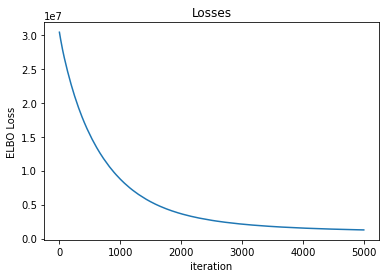

In [11]:
pseudo_time_reg_deconv.plot_loss()

In [12]:
pseudo_time_reg_deconv.calculate_composition_trajectories(n_intervals = 1000)

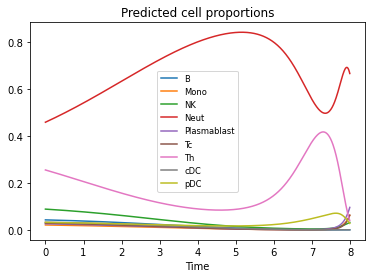

In [13]:
pseudo_time_reg_deconv.plot_composition_trajectories()

<AxesSubplot:xlabel='$\\phi_g$', ylabel='Counts'>

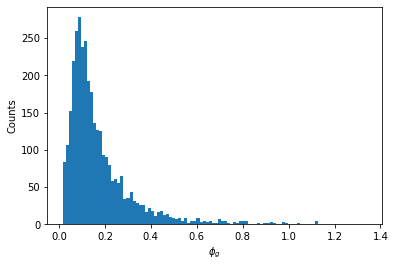

In [14]:
pseudo_time_reg_deconv.plot_phi_g_distribution()

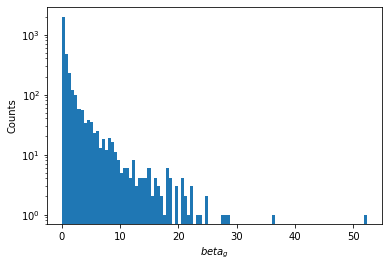

In [15]:
pseudo_time_reg_deconv.plot_beta_g_distribution()
matplotlib.pyplot.yscale('log')

# Synthetic Data

In [16]:
batch_dict = generate_batch(pseudo_time_reg_deconv.dataset, device, dtype)

## Evaluate Simulation 1 (100 samples; polynomial)

hi


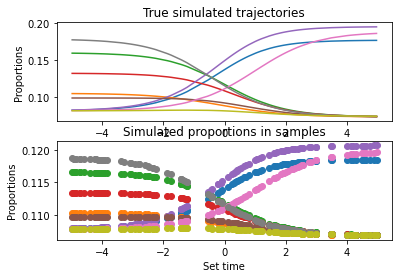

In [17]:
# Simulate and plot proportions
sim_res = simulate_with_sigmoid_proportions(
    num_samples=100, 
    reference_deconvolution=pseudo_time_reg_deconv,
    dirichlet_alpha = 1e10,
)


plot_simulated_proportions(sim_res)
matplotlib.pyplot.show()

In [18]:
simulated_bulk = generate_anndata_from_sim(sim_res, reference_deconvolution=pseudo_time_reg_deconv)

/opt/conda/lib/python3.7/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [19]:
ebov_simulated_dataset = DeconvolutionDataset(
    sc_anndata = sc_anndata,
    sc_celltype_col = "Subclustering_reduced",
    bulk_anndata = simulated_bulk,
    bulk_time_col = "time",
    dtype_np = dtype_np,
    dtype = dtype,
    device = device,
    feature_selection_method = 'common' 
)

In [20]:
pseudo_time_reg_deconv_sim = TimeRegularizedDeconvolution(
    dataset=ebov_simulated_dataset,
    polynomial_degree = 20,
    basis_functions = "polynomial",
    device=device,
    dtype=dtype)

In [21]:
pseudo_time_reg_deconv_sim.fit_model(n_iters=5_001, verbose=True, log_frequency=1000)

/opt/conda/lib/python3.7/site-packages/pyro/util.py:242: UserWarning: Found non-auxiliary vars in guide but not model, consider marking these infer={'is_auxiliary': True}:
{'cell_pop_mc'}
  guide_vars - aux_vars - model_vars))


[iteration: 0]   loss: 2253647.34
[iteration: 1000]   loss: 1854777.68
[iteration: 2000]   loss: 1659939.96
[iteration: 3000]   loss: 1581710.75
[iteration: 4000]   loss: 1557353.93
[iteration: 5000]   loss: 1551264.61


<AxesSubplot:title={'center':'Losses'}, xlabel='iteration', ylabel='ELBO Loss'>

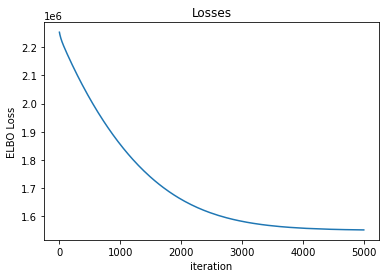

In [22]:
pseudo_time_reg_deconv_sim.plot_loss()

In [23]:
pseudo_time_reg_deconv_sim.calculate_composition_trajectories(n_intervals = 1000)

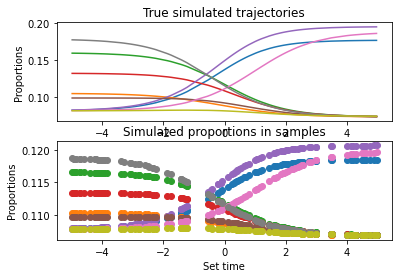

In [24]:
plot_simulated_proportions(sim_res)
matplotlib.pyplot.show()

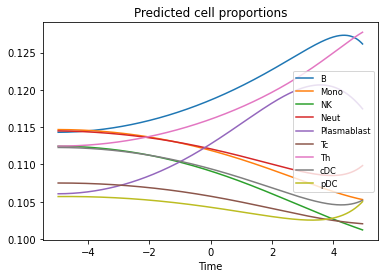

In [25]:
pseudo_time_reg_deconv_sim.plot_composition_trajectories()

In [26]:
calculate_prediction_error(sim_res, pseudo_time_reg_deconv_sim)

{'L1_error': tensor(2.5272),
 'L1_error_norm': tensor(0.2527),
 'L2_error': tensor(0.3089),
 'L2_error_norm': tensor(0.0309)}